# Domain adaptation analysis

### Initial settings

#### Dependencies

In [1]:
%pip install --user -qr ./requirements.txt 

Note: you may need to restart the kernel to use updated packages.


#### Import and Utilities

In [33]:
import pytorch_lightning as pl
# your favorite machine learning tracking tool
# from pytorch_lightning.loggers import WandbLogger

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

from torchmetrics import Accuracy

from torchvision import transforms

import wget 
import numpy as np
from matplotlib import pyplot as plt
# import wandb

### Import Dataset

In [3]:
# TODO: spostare questa implementazione in un file a parte
import os
import sys
import zipfile
from scripts.extract_patches import *
import shutil
import progressbar

bar = progressbar.ProgressBar(maxval=7240124142, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

def bar_progress(current, total, width=80):
  bar.update(current)

class CulturalSiteDatasetsLoader():

    def __init__(self, download_path):    
        self._class_path_datasets = './CLASS-EGO-CH-OBJ-ADAPT/' # TODO: non è detto che si chiami così, configurarlo in modo che sia così
        if not self._classification_datasets_exists():
            print("Classification dataset not found. Checking main dataset...")
            self._main_path_datasets = './EGO-CH-OBJ-ADAPT/'
            if not self._main_datasets_exists():
                print("Main dataset not found. Checking zip file dataset...")
                self._get_main_datasets(download_path) 
            else: print("Main dataset found.")
            print("Start extracting patches...")
            self._extract_patches(self._main_path_datasets, self._class_path_datasets)  
            print("Patches extracted successfully!")  
        else: print("Classification dataset found.")

    def _get_main_datasets(self, download_path): # download and extract dataset
        zip_file_path = './EGO-CH-OBJ-ADAPT.zip'
        if not self._main_datasets_zip_exists(zip_file_path):
            print("Zip file dataset not found. Pulling from resource(", download_path, ")...")
            bar.start()
            wget.download(download_path, "./", bar=bar_progress)
            bar.finish()
        self.extract_file(zip_file_path)
        
    def extract_file(self, zip_file_path):  
        print("Zip file found, start unzipping...")
        save_path = "./EGO-CH-OBJ-ADAPT/"
        with zipfile.ZipFile(zip_file_path) as zf:
            zf.extractall(save_path)     
        print("File unzipped successfully!")

    def _extract_patches(self, main_path, save_path):
        print(main_path, save_path)
        ExtractPatches(main_path, save_path).extract()

    def _main_datasets_exists(self):
        return os.path.isdir(self._main_path_datasets)

    def _main_datasets_zip_exists(self, zip_file_path):
        return os.path.isfile(zip_file_path)

    def _classification_datasets_exists(self):
        return os.path.isdir(self._class_path_datasets)

In [4]:
from typing import Callable, Optional
import json
from PIL import Image
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.datasets.vision import VisionDataset

class CulturalSiteDataset(VisionDataset):

    TRAIN = 0
    VALIDATION = 1
    TEST = 2

    REAL_DATASET = 0
    SYNTHETIC_DATASET = 1    

    REAL = "real"
    SYNTHETIC = "syntehtic"

    RESIZE_HEIGHT = 32
    RESIZE_WIDTH = 32

    def __init__(self, dataset_stage=TRAIN, dataset_type=SYNTHETIC_DATASET, transform: Optional[Callable] = None) -> None:
        data_domain = CulturalSiteDataset.REAL if dataset_type == CulturalSiteDataset.REAL_DATASET else CulturalSiteDataset.SYNTHETIC
        base_path = './CLASS-EGO-CH-OBJ-ADAPT'
        if dataset_stage == CulturalSiteDataset.TRAIN:
            dataset_folder = os.path.join(base_path, data_domain, 'training', 'data')
            labels_file = os.path.join(base_path, data_domain, 'training', 'labels.json')
        elif dataset_stage == CulturalSiteDataset.VALIDATION and dataset_type != CulturalSiteDataset.REAL_DATASET:
            dataset_folder = os.path.join(base_path, data_domain, 'validation', 'data')
            labels_file = os.path.join(base_path, data_domain, 'validation', 'labels.json')
        elif dataset_stage == CulturalSiteDataset.TEST or dataset_type == CulturalSiteDataset.REAL_DATASET:
            dataset_folder = os.path.join(base_path, data_domain, 'test', 'data')
            labels_file = os.path.join(base_path, data_domain, 'test', 'labels.json') 
        super().__init__(root = dataset_folder, transform = transform, target_transform=None)

        self.image_dataset = [] # [filename, img, id_class]
        self._load_images(dataset_folder)
        self._load_image_classes(labels_file) # todo: remove hardcode (add config file)
        self._load_class_ids(os.path.join("./utils", "image_classes.json")) # todo: remove hardcode o salvare 
        self.image_dataset = np.array(self.image_dataset, dtype=object)
        # todo: spostare in gpu se disponile

    def get_image_dataset(self):
        return self.image_dataset

    def set_image_dataset(self):
        return self.image_dataset

    def filter_dataset(self, soglia_pixel):
        filtered_dataset = filter(lambda x: x[1].shape[0] > soglia_pixel and x[1].shape[1] > soglia_pixel, self.image_dataset)
        self.image_dataset = np.array(filtered_dataset)

    def normalize_dataset(self):  
        normalized_dataset = []     
        for el in self.image_dataset:
            el[1] = np.asarray(Image.fromarray(el[1]).resize((CulturalSiteDataset.RESIZE_WIDTH, CulturalSiteDataset.RESIZE_HEIGHT)))
            normalized_dataset.append(el)
        self.image_dataset = np.array(normalized_dataset)

    def _load_images(self, path):
        suffix = ".jpg"
        for filename in os.listdir(path):
            im = Image.open(os.path.join(path, filename))
            self.image_dataset.append([filename.removesuffix(suffix), np.asarray(im), None ])

    def _load_image_classes(self, path):
        file = open(path)
        content = json.load(file)
        for el in self.image_dataset:
            el[2] = content["labels"][el[0]]

    def _load_class_ids(self, path):  # TODO: è possibile fare tutto in un unico passaggio nella funzione sopra, da sistemare
        file = open(path)
        content = json.load(file)
        for i in range(len(self.image_dataset)):
            for el in content["categories"]:
                if el["name"] == self.image_dataset[i][2]:
                    self.image_dataset[i][2] = el["id"]

    def __getitem__(self, index: int):
        img = self.image_dataset[index][1]
        image_class = self.image_dataset[index][2]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, image_class


    def __len__(self) -> int:
        return len(self.image_dataset)

In [17]:
class CulturalSiteDataModule(pl.LightningDataModule):

    FIT_STAGE = 0
    TEST_STAGE = 1
    ALL_STAGE = 2

    REAL_DATASET = 0
    SYNTHETIC_DATASET = 1

    def __init__(self, batch_size, dataset_type, num_classes):
        super().__init__()
        self.batch_size = batch_size
        self.dataset_type = dataset_type
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Todo: controllare questa normalizzazione (zero mean normalizzation)
        ])
        self.num_classes = num_classes
        self.cultural_site_train = None
        self.cultural_site_val = None
        self.cultural_site_test = None
    
    def prepare_data(self):
        CulturalSiteDatasetsLoader("https://iplab.dmi.unict.it/EGO-CH-OBJ-ADAPT/EGO-CH-OBJ-ADAPT.zip") # todo: rimuovere hardcode
        #CulturalSiteDataset() #dovremmo usare questa classe anziché il loader. O comunque l'importante qui è preparare i dati per averli pronti dopo

    def setup(self, stage=ALL_STAGE):
        # TODO: qui istanziare CulturalSiteDataset, creare i dataset da passare ai dataloader sotto
        # Assign train/val datasets for use in dataloaders
        if stage == CulturalSiteDataModule.FIT_STAGE or stage == CulturalSiteDataModule.ALL_STAGE:
            self.cultural_site_train = CulturalSiteDataset(dataset_stage=CulturalSiteDataset.TRAIN, dataset_type=self.dataset_type, transform=self.transform)
            if self.dataset_type == CulturalSiteDataModule.SYNTHETIC_DATASET:
                self.cultural_site_val = CulturalSiteDataset(dataset_stage=CulturalSiteDataset.VALIDATION, dataset_type=self.dataset_type, transform=self.transform)
            else:
                self.cultural_site_val = CulturalSiteDataset(dataset_stage=CulturalSiteDataset.TEST, dataset_type=self.dataset_type, transform=self.transform)

        # Assign test dataset for use in dataloader(s)
        if stage == CulturalSiteDataModule.TEST_STAGE or stage == CulturalSiteDataModule.ALL_STAGE:
            self.cultural_site_test = CulturalSiteDataset(dataset_stage=CulturalSiteDataset.TEST, dataset_type=self.dataset_type, transform=self.transform)
    
    def train_preanalysis(self, subplot, title):
        return self.__ds_preanalysis(self.cultural_site_train, subplot, title)

    def val_preanalysis(self, subplot, title):
        return self.__ds_preanalysis(self.cultural_site_val, subplot, title)

    def test_preanalysis(self, subplot, title):
        return self.__ds_preanalysis(self.cultural_site_test, subplot, title)

    def __ds_preanalysis(self, dataset: CulturalSiteDataset, subplot, title):
        image_dataset = dataset.get_image_dataset()
        unique, counts = np.unique(image_dataset[:, 2], return_counts=True)
        subplot.bar(unique, counts)
        subplot.set_xticks(unique.astype(np.float32))
        for index, value in enumerate(list(counts)):
            subplot.text(index, value, str(value))
        subplot.set_title(title)
        return subplot
        # print(np.column_stack((unique,counts)))
        # print("len: ", len(image_dataset))

    def filter_train(self, soglia_pixel):
        self.cultural_site_train.filter_dataset(soglia_pixel)

    def filter_val(self, soglia_pixel):
        self.cultural_site_val.filter_dataset(soglia_pixel)

    def filter_test(self, soglia_pixel):
        self.cultural_site_test.filter_dataset(soglia_pixel)

    def normalize_train(self):
        prev_image = self.cultural_site_train.get_image_dataset()[0][1]
        self.cultural_site_train.normalize_dataset()
        dataset = self.cultural_site_train.get_image_dataset()
        fig, (prev_subplot, post_subplot) = plt.subplots(1, 2)
        prev_subplot.set_title("Immagine originale " + str(prev_image.shape[0]) + "x" + str(prev_image.shape[1]) + ":")
        post_subplot.set_title("Immagine normalizzata " + str(CulturalSiteDataset.RESIZE_HEIGHT) + "x" + str(CulturalSiteDataset.RESIZE_WIDTH) + ":")
        prev_subplot.imshow(prev_image)
        post_subplot.imshow(dataset[0][1])      
        print(dataset[0][0], dataset[0][2])      

    def normalize_val(self):
        self.cultural_site_val.normalize_dataset()

    def normalize_test(self):
        self.cultural_site_test.normalize_dataset()

    def train_dataloader(self):
        return DataLoader(self.cultural_site_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cultural_site_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cultural_site_test, batch_size=self.batch_size)

### Dataset Pre Analysis

In [6]:
dm = CulturalSiteDataModule(batch_size=32, dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, num_classes=16) # todo: istanziare CulturalSiteDataset, preparare i dati
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


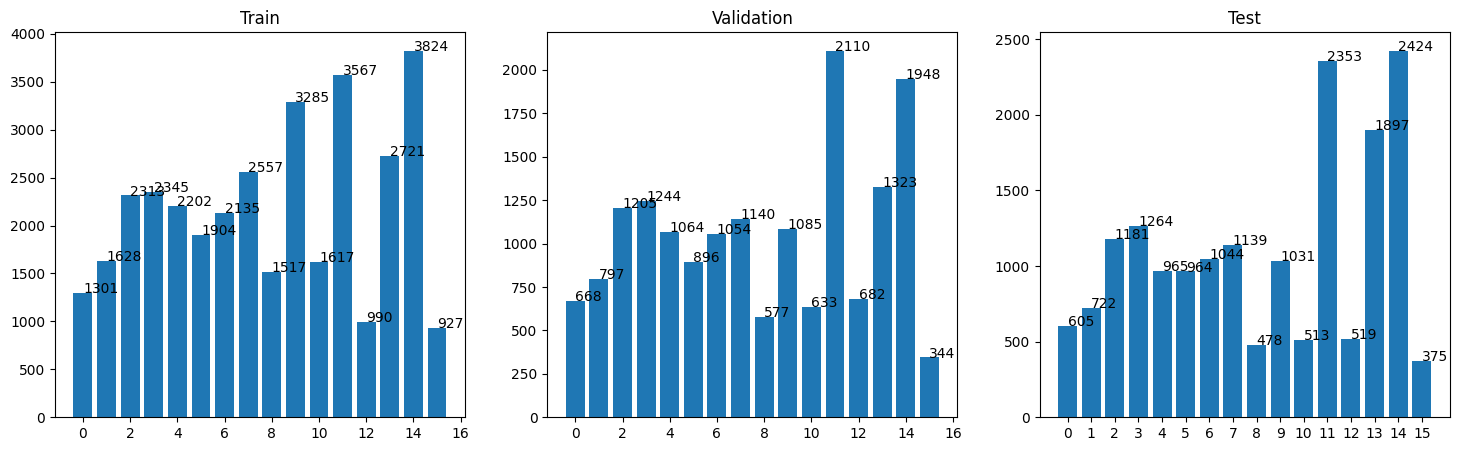

In [21]:
fig, (train_subplot, val_subplot, test_subplot) = plt.subplots(1, 3)
dm.train_preanalysis(train_subplot, 'Train')
dm.val_preanalysis(val_subplot, 'Validation')
dm.test_preanalysis(test_subplot, 'Test')
fig.set_size_inches(22, 6)
plt.show()

Si è notato che alcune immagini non rapresetavano pienamente le caratteristiche dell'oggetto da classificare, per cui si è optato di scartare le immaggini con meno di 30px per lato.

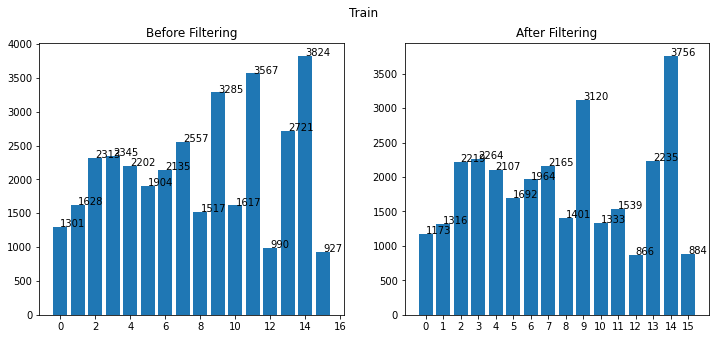

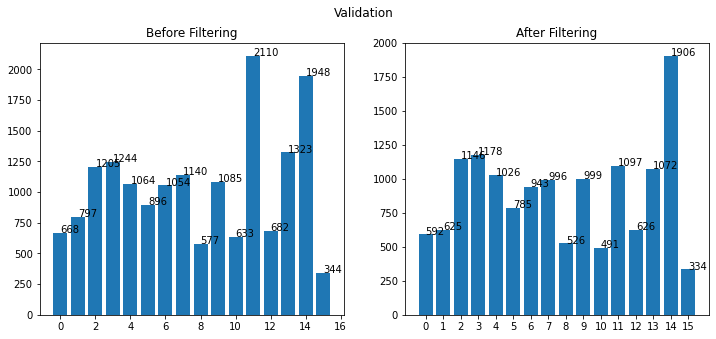

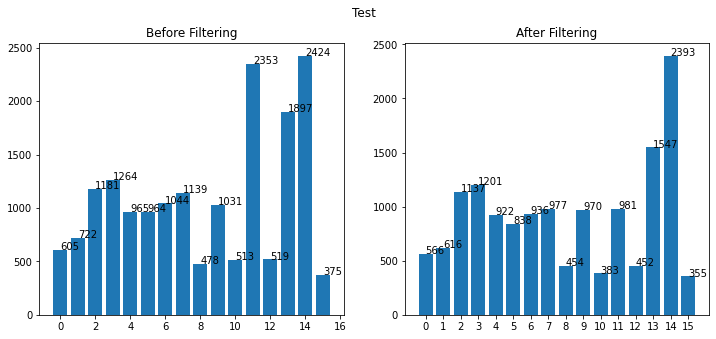

In [24]:
soglia_pixel = 30
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
dm.filter_train(soglia_pixel)
dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
dm.filter_val(soglia_pixel)
dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test(soglia_pixel)
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')

plt.show()


### Normalize input features

003301 2


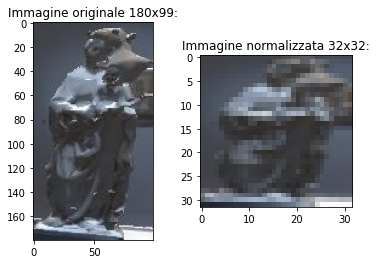

In [10]:
dm.normalize_train()
dm.normalize_val()
dm.normalize_test()

## Domain adaptation study cases

### 1. Baseline approaches without adaption
Il primo caso di studio è quello di allenare il classificatore sul sintetico e poi testarlo nudo e crudo sul reale, valutare le performance

### Classification Module

In [10]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)

        self.pool1 = torch.nn.MaxPool2d(2)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        n_sizes = self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(n_sizes, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.accuracy = Accuracy()

    # returns the size of the output tensor going into Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        return x
    
    # will be used during inference
    def forward(self, x):
       x = self._forward_features(x)
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.log_softmax(self.fc3(x), dim=1)
       
       return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


### Model Training

#### 1)  the model is trained on synthetic images and tested on synthetic images (no domain shift)

In [11]:
model = LitModel((3, 32, 32), dm.num_classes)

# todo: inizializzare il logger, utilizzeremo tensorboard come anno scorso
# Initialize wandb logger
# wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=10,
                     accelerator="gpu", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     devices=1,
                     # logger=wandb_logger,
                     callbacks=[early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                checkpoint_callback],
                     )

# Train the model ⚡🚅⚡
trainer.fit(model, dm)

# Evaluate the model on the held-out test set ⚡⚡
trainer.test(dataloaders=dm.test_dataloader())

# Close wandb run
# wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 9.2 K 
2 | conv3    | Conv2d    | 18.5 K
3 | conv4    | Conv2d    | 36.9 K
4 | pool1    | MaxPool2d | 0     
5 | pool2    | MaxPool2d | 0     
6 | fc1      | Linear    | 819 K 
7 | fc2      | Linear    | 65.7 K
8 | fc3      | Linear    | 2.1 K 
9 | accuracy | Accuracy  | 0     
---------------------------------------
953 K     Trainable params
0         Non-trainable params
953 K     Total params
3.812     Total estimated model params size (MB)


Classification dataset found.


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at e:\github\deep-learning-project\lightning_logs\version_7\checkpoints\epoch=9-step=9390.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\lightning_logs\version_7\checkpoints\epoch=9-step=9390.ckpt



Classification dataset found.


c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9473791122436523
        test_loss           0.1824977546930313
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1824977546930313, 'test_acc': 0.9473791122436523}]

In [12]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

####  2) the model is trained on synthetic images and tested on real images (no adaptation)

In [13]:
dm = CulturalSiteDataModule(batch_size=32, dataset_type=CulturalSiteDataModule.REAL_DATASET, num_classes=16) # todo: istanziare CulturalSiteDataset, preparare i dati
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(CulturalSiteDataModule.TEST_STAGE)

Classification dataset found.


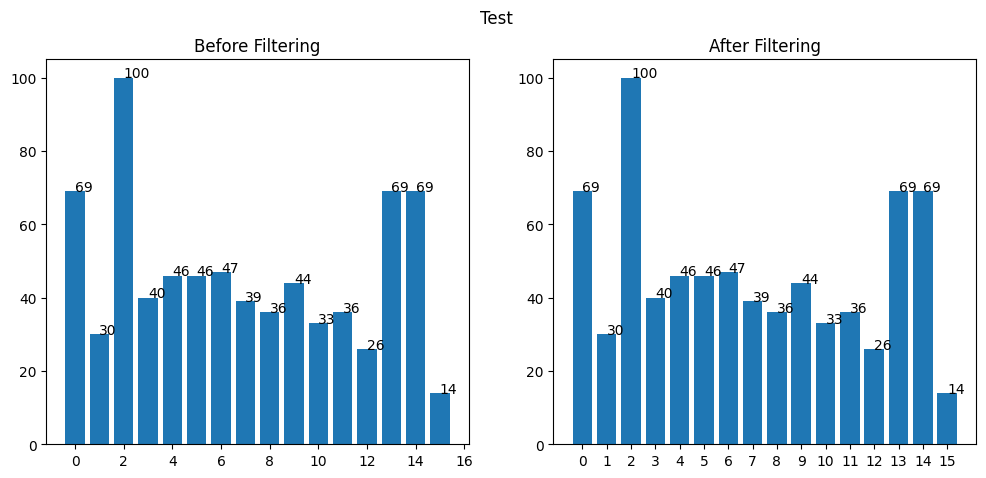

In [15]:
test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test()
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')
plt.show()

dm.normalize_test()

In [16]:
trainer.test(dataloaders=dm.test_dataloader())

Restoring states from the checkpoint path at e:\github\deep-learning-project\lightning_logs\version_3\checkpoints\epoch=9-step=9390.ckpt
Loaded model weights from checkpoint at e:\github\deep-learning-project\lightning_logs\version_3\checkpoints\epoch=9-step=9390.ckpt


Classification dataset found.
Testing: 0it [04:30, ?it/s]
Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 85.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.11559139937162399
        test_loss            28.88227653503418
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 28.88227653503418, 'test_acc': 0.11559139937162399}]

 #### 3) the model is trained on real images and tested on real images

In [18]:
dm = CulturalSiteDataModule(batch_size=32, dataset_type=CulturalSiteDataModule.REAL_DATASET, num_classes=16) # todo: istanziare CulturalSiteDataset, preparare i dati
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


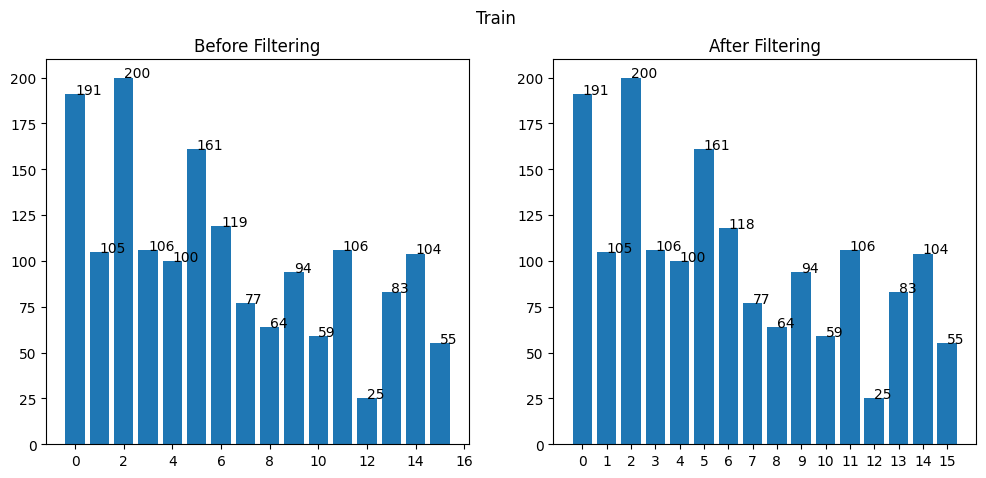

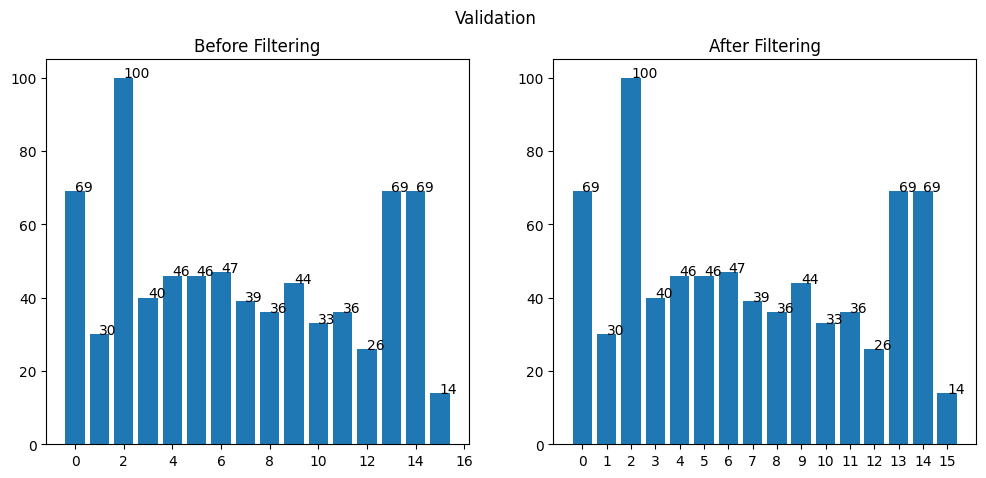

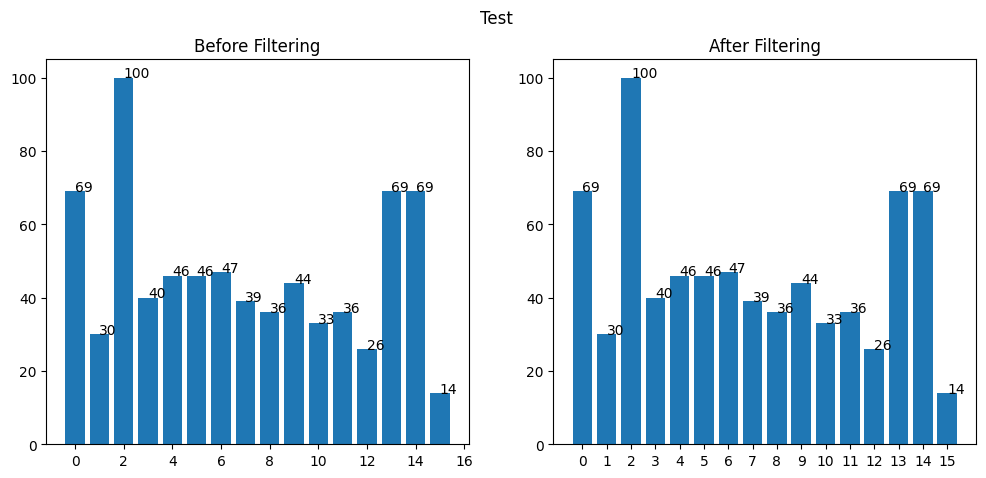

In [19]:
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
dm.filter_train()
dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
dm.filter_val()
dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test()
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')

plt.show()

In [22]:
model = LitModel((3, 32, 32), dm.num_classes)

# todo: inizializzare il logger, utilizzeremo tensorboard come anno scorso
# Initialize wandb logger
# wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=100,
                     accelerator="gpu", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     devices=1,
                     # logger=wandb_logger,
                     callbacks=[early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                checkpoint_callback],
                     )

# Train the model ⚡🚅⚡
trainer.fit(model, dm)

# Evaluate the model on the held-out test set ⚡⚡
trainer.test(dataloaders=dm.test_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 9.2 K 
2 | conv3    | Conv2d    | 18.5 K
3 | conv4    | Conv2d    | 36.9 K
4 | pool1    | MaxPool2d | 0     
5 | pool2    | MaxPool2d | 0     
6 | fc1      | Linear    | 819 K 
7 | fc2      | Linear    | 65.7 K
8 | fc3      | Linear    | 2.1 K 
9 | accuracy | Accuracy  | 0     
---------------------------------------
953 K     Trainable params
0         Non-trainable params
953 K     Total params
3.812     Total estimated model params size (MB)


Classification dataset found.
Epoch 26: 100%|██████████| 76/76 [00:02<00:00, 34.46it/s, loss=0.426, v_num=5, val_loss=1.100, val_acc=0.726]

Restoring states from the checkpoint path at e:\github\deep-learning-project\lightning_logs\version_5\checkpoints\epoch=26-step=1404.ckpt
Loaded model weights from checkpoint at e:\github\deep-learning-project\lightning_logs\version_5\checkpoints\epoch=26-step=1404.ckpt



Classification dataset found.
Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 82.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.725806474685669
        test_loss            1.098347544670105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.098347544670105, 'test_acc': 0.725806474685669}]

In [33]:
im = Image.open("E:/github/deep-learning-project/CLASS-EGO-CH-OBJ-ADAPT/real/test/data/000001.jpg").resize((CulturalSiteDataset.RESIZE_WIDTH, CulturalSiteDataset.RESIZE_HEIGHT))
pl.imgshow(im)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Todo: controllare questa normalizzazione (zero mean normalizzation)
])
img = transform(im)
print(model.forward(img))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x25 and 1600x512)